# Offsite Test2

## 1. Read Data

In [78]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import*
from pyspark.sql.types import*
from datetime import datetime as dt, timedelta
from pyspark.sql import Window

Ininialize spark session which run in local use 4 threads 

In [79]:
# Initialise spark session 
spark = SparkSession.builder.master('local[4]').getOrCreate()

In [80]:
#Set spark session timezone to UTC
spark.conf.set("spark.sql.session.timeZone", "UTC")

In [81]:
sqlContext = SQLContext(spark)

* Notes: Download the files from the link and rename to partx.parquet

In [82]:
# Read parquet file
df = sqlContext.read.parquet("part0.parquet","part1.parquet","part2.parquet","part3.parquet")

## 2. Data Understanding

In [83]:
# Total Record
df.count()

1303198

In [84]:
# View Schema
df.printSchema()

root
 |-- server_ts: long (nullable = true)
 |-- e_n: string (nullable = true)
 |-- uid: string (nullable = true)
 |-- device: string (nullable = true)



In [85]:
#Preview Data
df.show(5)

+-------------+------------------+--------+------+
|    server_ts|               e_n|     uid|device|
+-------------+------------------+--------+------+
|1526834759526|{"article_id":897}|d8ab96a3|mobile|
|1526834759498|{"article_id":288}|fcc4523f|mobile|
|1526834759837|{"article_id":342}|43268f68|mobile|
|1526834760073|{"article_id":970}|e66f2fd5|mobile|
|1526834760056|{"article_id":827}|aaabad9b|mobile|
+-------------+------------------+--------+------+
only showing top 5 rows



## 3. Data Cleaning

In [86]:
# Check null value
def count_not_null(c, nan_as_null=False):
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)

df.agg(*[count_not_null(c) for c in df.columns]).show()

+---------+-------+-------+-------+
|server_ts|    e_n|    uid| device|
+---------+-------+-------+-------+
|  1303198|1303198|1303079|1303198|
+---------+-------+-------+-------+



* Filter records with null in u_id

In [87]:
df = df.filter(df.uid.isNotNull())

In [88]:
# Ensure no null values
df.agg(*[count_not_null(c) for c in df.columns]).show()

+---------+-------+-------+-------+
|server_ts|    e_n|    uid| device|
+---------+-------+-------+-------+
|  1303079|1303079|1303079|1303079|
+---------+-------+-------+-------+



* Extract article_id from json string

In [89]:
# Extract article_id from json string
df = df.select('server_ts',json_tuple(df.e_n,'article_id').alias("article_id"),'uid','device')  

* Convert server timestamp to datetime in GMT time zone

In [90]:
# Define convert_datetime function 
def convert_datetime(m_seconds) : 
    gmt_datetime=dt(1970, 1, 1) + timedelta(milliseconds= m_seconds)
    dtStr = gmt_datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")
    return dtStr

In [91]:
# Register convert_datetime function
dtfmt = udf(convert_datetime, StringType())

In [92]:
# Apply function
df = df.withColumn('gmt_datetime', dtfmt(df.server_ts))

In [93]:
df.show(5)

+-------------+----------+--------+------+--------------------+
|    server_ts|article_id|     uid|device|        gmt_datetime|
+-------------+----------+--------+------+--------------------+
|1526834759526|       897|d8ab96a3|mobile|2018-05-20T16:45:...|
|1526834759498|       288|fcc4523f|mobile|2018-05-20T16:45:...|
|1526834759837|       342|43268f68|mobile|2018-05-20T16:45:...|
|1526834760073|       970|e66f2fd5|mobile|2018-05-20T16:46:...|
|1526834760056|       827|aaabad9b|mobile|2018-05-20T16:46:...|
+-------------+----------+--------+------+--------------------+
only showing top 5 rows



In [94]:
# Extract date and hour from gmt_datetime
df = df.withColumn('view_date', date_format(df.gmt_datetime.cast('timestamp'), 'yyyy-MM-dd').cast('date'))\
          .withColumn('view_hr', lpad(hour(df.gmt_datetime),2,'0'))

* Check any record is not on '2018-05-20'

In [95]:
#Check any date not in 2018-05-20
df.filter(df.view_date!='2018-05-20').count()

99

In [96]:
#View records 
df_check = df.filter(df.view_date!='2018-05-20')

In [97]:
df_check.select("gmt_datetime","view_date","view_hr").head(5)

[Row(gmt_datetime='2018-05-21T00:00:00.241000', view_date=datetime.date(2018, 5, 21), view_hr='00'),
 Row(gmt_datetime='2018-05-21T00:00:00.296000', view_date=datetime.date(2018, 5, 21), view_hr='00'),
 Row(gmt_datetime='2018-05-21T00:00:00.238000', view_date=datetime.date(2018, 5, 21), view_hr='00'),
 Row(gmt_datetime='2018-05-21T00:00:00.338000', view_date=datetime.date(2018, 5, 21), view_hr='00'),
 Row(gmt_datetime='2018-05-21T00:00:00.714000', view_date=datetime.date(2018, 5, 21), view_hr='00')]

In [98]:
df_check.select("gmt_datetime","view_date","view_hr").groupBy("view_date","view_hr").count().show()

+----------+-------+-----+
| view_date|view_hr|count|
+----------+-------+-----+
|2018-05-21|     00|   99|
+----------+-------+-----+



 - All records are on 2018-05-21 ,  those records should be filtered

In [99]:
# Filter records with date not in '2018-05-20'
df = df.filter(df.view_date =='2018-05-20')

In [100]:
# Ensure those records are filtered
df.filter(df.view_date !='2018-05-20').count()

0

In [101]:
# Updated total records
df.count()

1302980

- Completed data cleaning

# Q1 Page View Events Analysis

## Q1a The total number of pageviews

In [102]:
#Q1a Total pageviews
df.count()

1302980

## Q1b The greatest view article

- Article id 827 has greatest pageviews which is 49243

In [103]:
#Q1b The greatest view article
df.groupBy("article_id").count().orderBy('count', ascending=False).show(1)

+----------+-----+
|article_id|count|
+----------+-----+
|       827|49243|
+----------+-----+
only showing top 1 row



## Q1c Greatest view article in each hour

In [104]:
#Check any invalid hour
df.where((col("view_hr").isNull()) | (col("view_hr")>24)).show()

+---------+----------+---+------+------------+---------+-------+
|server_ts|article_id|uid|device|gmt_datetime|view_date|view_hr|
+---------+----------+---+------+------------+---------+-------+
+---------+----------+---+------+------------+---------+-------+



In [105]:
df_agg_hr = df.groupBy("view_hr","article_id").count()

In [106]:
# Create window partition by hour and order descending by count
window = Window.partitionBy(df_agg_hr['view_hr']).orderBy(df_agg_hr['count'].desc())

In [107]:
# Get the article with greatest pagesview in each hour
df_1c = df_agg_hr.select('*', rank().over(window).alias('rank')) \
  .filter(col('rank') <= 1) 

In [108]:
# Display the table
df_1c.select(df_1c.view_hr.alias('hour') ,'article_id','count').orderBy('hour').show(24)

+----+----------+-----+
|hour|article_id|count|
+----+----------+-----+
|  00|       830| 3105|
|  01|       155| 4933|
|  02|       830| 2914|
|  03|       374| 5404|
|  04|       374| 6139|
|  05|       897| 4418|
|  06|       813| 3214|
|  07|       740| 2517|
|  08|       712| 3045|
|  09|       712| 1937|
|  10|       827| 6702|
|  11|       827| 7198|
|  12|       827| 6428|
|  13|       827| 5518|
|  14|       827| 4806|
|  15|        67| 6942|
|  16|       827| 3139|
|  17|       871| 2274|
|  18|       827| 1072|
|  19|       827|  696|
|  20|       827|  391|
|  21|       827|  430|
|  22|        85| 1636|
|  23|        85| 4229|
+----+----------+-----+



### Visualization on Q1c

In [109]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [110]:
#Visualization
df_pd = df_1c.toPandas()

In [111]:
df_pd_sort = df_pd.sort_values(by=['count'],ascending=False)

In [112]:
df_pd_sort.head()

,view_hr,article_id,count,rank
2,11,827,7198,1
1,15,67,6942,1
18,10,827,6702,1
19,12,827,6428,1
20,04,374,6139,1


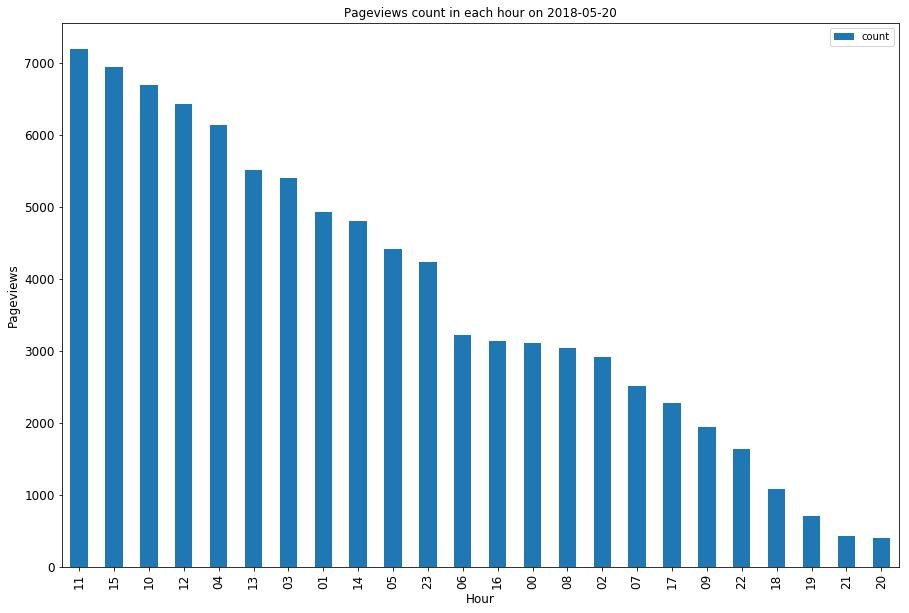

In [113]:
# Create a bar plot
ax = df_pd_sort.plot(x='view_hr', y='count', kind='bar', title ="Pageviews count in each hour on 2018-05-20", \
                figsize=(15,10),legend=True, fontsize=12)
ax.set_xlabel("Hour",fontsize=12)
ax.set_ylabel("Pageviews",fontsize=12)


- 10am-12noon and 3:00pm are top 4 pageviews period

## Q1d Average and Median number of pageviews per user

 - No. of unique user is 543069 (Notes: All users without id count as 1 user)

In [114]:
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

+---------+----------+------+------+------------+---------+-------+
|server_ts|article_id|   uid|device|gmt_datetime|view_date|view_hr|
+---------+----------+------+------+------------+---------+-------+
|  1291262|       997|543068|     2|     1291262|        1|     24|
+---------+----------+------+------+------------+---------+-------+



In [115]:
# Sort the pageviews count per user in ascending order
df_agg = df.groupBy("uid").count().orderBy("count")

* The average pageviews per user is 2.3995

In [116]:
#Average
df_agg.agg({"count": "avg"}).show()

+-----------------+
|       avg(count)|
+-----------------+
|2.399294379341077|
+-----------------+



* The median pageviews per user is 1

In [117]:
#Median
df_agg.approxQuantile("count", [0.5], 0.25)

[1.0]

 * Check median

In [118]:
check_median = df_agg.toPandas()

In [119]:
check_median.head()

,uid,count
0,238b41ee,1
1,11680de7,1
2,a1f3350f,1
3,4ea36de8,1
4,15045d2f,1


In [120]:
check_median['count'].median()

1.0

# Q2 User Session Analysis

 - Transform to session dataframe

In [121]:
# Create a new dataframe sort by uid and server timestamp
df_q2 = df.sort('uid','server_ts')

In [122]:
# Define a function to find session legnth 
# x should be a list of timestamp of each user
def findSession(x):
    # define first and last variable and set to 0
    # first = session start timestamp , last = previous timestamp
    first = last = 0
    # create a list to store every session length
    durations = []
    # loop every elemenet in the list
    for row in x:
        if (first == 0):
            # store row to first for every session start
            first = row
            # check new session
        if((row - first) > 30*60*1000):
            # store timestamp between first and last pages view as session length
            durations.append(last - first)
            #print('Found session from', first, ' to ', last, 'session length:', (last-first))
            # set current timestamp as new session start
            first = row
        # update last variable    
        last = row
    # add final session length
    durations.append(last - first)
    #print('Found final session from', first, ' to ', last, 'session length:', (last-first))
    # return a list of session length of the user
    return durations

In [123]:
# Register function
udf_findSession = udf(findSession, ArrayType(IntegerType()))

In [124]:
# Group all timestamp by user id and store as list in ts column
# Add session length column from findSession() 
df_group = df_q2.groupBy('uid').agg(collect_list(df_q2.server_ts).alias('ts')). \
            withColumn('sessionLength', udf_findSession('ts'))

In [125]:
# Explode session length list to row for each user 
df_session = df_group.select('uid',explode('sessionLength').alias('sessionLength'))

 - Transformed to session dataframe

In [126]:
df_session.show()

+--------+-------------+
|     uid|sessionLength|
+--------+-------------+
|000cd7dd|       811365|
|004abcf8|            0|
|00723ac0|            0|
|0074550b|       888207|
|0074550b|            0|
|0074550b|            0|
|0075fc8c|       229361|
|00a345f2|            0|
|00cc9468|            0|
|00d8e6a1|            0|
|00d8edce|        97143|
|00d8edce|       459686|
|00d8edce|       369315|
|00d8edce|       886920|
|00d8edce|            0|
|00d8edce|            0|
|00ec39ee|       718182|
|00f59c56|            0|
|00f7ff75|            0|
|010112bd|            0|
+--------+-------------+
only showing top 20 rows



## Q2a Total number of sessions

 * There are total 774467 sessions on 2018-05-20

In [127]:
df_session.count()

774467

## Q2b User with largest number of session

 * User with id c82275f3 has the 39 sessions which is the greatest

In [128]:
df_session.groupBy('uid').count().orderBy('count',ascending=False).show(1)

+--------+-----+
|     uid|count|
+--------+-----+
|c82275f3|   39|
+--------+-----+
only showing top 1 row



## Q2c Average and median of session length

 * The average session length is 141702.1 (~2.36 mins) 

In [131]:
#Average
df_session.agg({"sessionLength": "avg"}).show()

+------------------+
|avg(sessionLength)|
+------------------+
| 141702.1004377187|
+------------------+



 * The median session length is 0

In [132]:
#Median
df_session.sort("sessionLength").approxQuantile("sessionLength", [0.5], 0.25)

[0.0]

* Check median

In [133]:
check_median2 = df_session.toPandas()

In [134]:
check_median2['sessionLength'].median()

0.0

## 5. Testing 

 #### i. Test Case

| Test case  |   User id   | Description  |  Result  |
|:----------:|:-----------:|---|---|:-:|
|      1     |   004abcf8  | User clicks only once in the  whole day  |  Pass  |
|      2     |   000cd7dd  | User clicks within 30 mins and  does not click in the rest of day  | Pass  |
|      3     |   0346a137  | User clicks second time  after 30 mins of the first click  | Pass |
|      4     |   01afa787  | User clicks 4 times per day but time interval >30 mins between each clicks  |  Pass  |
|      5     |   00d8edce  | User clicks serveral times in each session  | Pass  |

* Notes: Test details are listed in test_log.excel

#### ii.Test Function

   * Create a test function on findSession with 5 test cases

In [135]:
def findSession_Test():
    
    # Test Case 1 - User clicks only once in the  whole day
    input1 = [1526835814516]
    result = findSession(input1)
    expected_result = [0]
    assert result == expected_result
    print("Test 1 successful")
    
    # Test Case 2 - User clicks within 30 mins and does not click in the rest of day
    input2 = [1526799963986,1526800253259,1526800399991,1526800509294,1526800775351]
    result = findSession(input2)
    expected_result = [811365]
    assert result == expected_result
    print("Test 2 successful")
    
    # Test Case 3 - User clicks second time after 30 mins of the first click
    input3 = [1526787725619,1526825846350,1526825865182]
    result = findSession(input3)
    expected_result = [0,18832]
    assert result == expected_result
    print("Test 3 successful")
    
    # Test Case 4 - User clicks 4 times per day but time interval >30 mins between each click
    input4 = [1526777752265,1526782639489,1526830729934,1526834621842]
    result = findSession(input4)
    expected_result = [0,0,0,0]
    assert result == expected_result
    print("Test 4 successful")
    
    # Test Case 5 - User clicks serveral times in fisrt 4 sessions and click again after 30mins
    input5 = [1526778130709,1526778227852,1526780165492,1526780188969,1526780214247,1526780625178,
              1526791616575,1526791694574,1526791985890,1526801416242,1526801505549,1526802303162,
            1526812445582,1526828731830]
    result = findSession(input5)
    expected_result = [97143,459686,369315,886920,0,0]
    assert result == expected_result
    print("Test 5 successful")

In [136]:
findSession_Test()

Test 1 successful
Test 2 successful
Test 3 successful
Test 4 successful
Test 5 successful


In [137]:
# Checking user timestamp and session by user id
user_id = "00d8edce"
df_q2.select("uid","server_ts","gmt_datetime").filter(df_q2['uid'] == user_id).show()
df_session.filter(df_session['uid'] == user_id).show()

+--------+-------------+--------------------+
|     uid|    server_ts|        gmt_datetime|
+--------+-------------+--------------------+
|00d8edce|1526778130709|2018-05-20T01:02:...|
|00d8edce|1526778227852|2018-05-20T01:03:...|
|00d8edce|1526780165492|2018-05-20T01:36:...|
|00d8edce|1526780188969|2018-05-20T01:36:...|
|00d8edce|1526780214247|2018-05-20T01:36:...|
|00d8edce|1526780625178|2018-05-20T01:43:...|
|00d8edce|1526791616575|2018-05-20T04:46:...|
|00d8edce|1526791694574|2018-05-20T04:48:...|
|00d8edce|1526791985890|2018-05-20T04:53:...|
|00d8edce|1526801416242|2018-05-20T07:30:...|
|00d8edce|1526801505549|2018-05-20T07:31:...|
|00d8edce|1526802303162|2018-05-20T07:45:...|
|00d8edce|1526812445582|2018-05-20T10:34:...|
|00d8edce|1526828731830|2018-05-20T15:05:...|
+--------+-------------+--------------------+

+--------+-------------+
|     uid|sessionLength|
+--------+-------------+
|00d8edce|        97143|
|00d8edce|       459686|
|00d8edce|       369315|
|00d8edce|       8869

End of the test 